In [379]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import re
import scrapy
import sys, inspect
from scrapy.spiders import Spider
from scrapy import Selector
import json
%config IPCompleter.use_jedi = False
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib.ticker as mtick


%matplotlib inline
import matplotlib
from collections import Counter
matplotlib.rcdefaults()
plt.style.use('tableau-colorblind10')

### URLS
From MoH
https://github.com/MoH-Malaysia/covid19-public

In [377]:
cases_malaysia = 'https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/epidemic/cases_malaysia.csv'
cases_state = 'https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/epidemic/cases_state.csv'
kluster = 'https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/epidemic/clusters.csv'
death_malaysia = 'https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/epidemic/deaths_malaysia.csv'
death_state = 'https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/epidemic/deaths_state.csv'
hospital = 'https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/epidemic/hospital.csv'
icu ='https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/epidemic/icu.csv'
pkrc = 'https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/epidemic/pkrc.csv'
tests_malaysia ='https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/epidemic/tests_malaysia.csv'
pop = 'https://raw.githubusercontent.com/CITF-Malaysia/citf-public/main/static/population.csv'

From CITF
https://github.com/CITF-Malaysia/citf-public/tree/main/vaccination

In [378]:
vax_state = 'https://raw.githubusercontent.com/CITF-Malaysia/citf-public/main/vaccination/vax_state.csv'
vax_malaysia = 'https://raw.githubusercontent.com/CITF-Malaysia/citf-public/main/vaccination/vax_malaysia.csv'

### Read Files

In [380]:
df_cases_malaysia = pd.read_csv(cases_malaysia)
df_cases_state = pd.read_csv(cases_state)
df_kluster = pd.read_csv(kluster)
df_death_malaysia = pd.read_csv(death_malaysia)
df_death_state = pd.read_csv(death_state)
df_hospital = pd.read_csv(hospital)
df_icu = pd.read_csv(icu)
df_pkrc = pd.read_csv(pkrc)
df_tests_malaysia = pd.read_csv(tests_malaysia)
df_vax_state = pd.read_csv(vax_state)
df_vax_malaysia = pd.read_csv(vax_malaysia)

df_population = pd.read_csv(pop)
malaysia_pop = df_population.loc[0,'pop']

df_list = [df_cases_malaysia, df_cases_state, df_kluster, df_death_malaysia, df_death_state,df_hospital,df_icu,
          df_pkrc,df_tests_malaysia,df_vax_state,df_vax_malaysia]

df_list_state = [df_cases_state,df_death_state,df_hospital,df_icu,df_pkrc,df_vax_state]

#Rename ICU terms for easier understanding
icu_mapper = {'bed_icu' : 'gazetted_ICU_beds',
 'bed_icu_rep' : 'critcare_anaesth_beds',
 'bed_icu_total' : 'total_beds',
 'bed_icu_covid' : 'beds_for_covid',
 'vent' : 'vent_avail',
 'vent_port' : 'portable_vent_avail',
 'icu_covid' : 'covid_in_icu',
 'icu_pui' : 'pui_in_icu',
 'icu_noncovid' : 'noncovid_in_icu',
 }
df_icu.rename(columns=icu_mapper, inplace=True)

#Map "Penang" to "Pulau Pinang"
penang_mapper = {'Penang':'Pulau Pinang'}
for x in df_list_state:
    x.state = x.state.replace(penang_mapper)

Plot Vax vs Death Rate in Malaysia

In [19]:
list_of_states = [*df_cases_state.state.unique()]
print(list_of_states)

['Johor', 'Kedah', 'Kelantan', 'Melaka', 'Negeri Sembilan', 'Pahang', 'Pulau Pinang', 'Perak', 'Perlis', 'Sabah', 'Sarawak', 'Selangor', 'Terengganu', 'W.P. Kuala Lumpur', 'W.P. Labuan', 'W.P. Putrajaya']


In [67]:
#Plot using function

In [32]:
states = [a for a in df_population.state[1:]]


['Johor',
 'Kedah',
 'Kelantan',
 'Melaka',
 'Negeri Sembilan',
 'Pahang',
 'Perak',
 'Perlis',
 'Pulau Pinang',
 'Sabah',
 'Sarawak',
 'Selangor',
 'Terengganu',
 'W.P. Kuala Lumpur',
 'W.P. Labuan',
 'W.P. Putrajaya']

In [109]:
df_population[df_population.state == 'Selangor']['pop'].values[0]

6538000

In [256]:
df_vax_state[df_vax_state.state == 'Selangor'].head()

,date,state,daily_partial,daily_full,daily,cumul_partial,cumul_full,cumul,pfizer1,pfizer2,sinovac1,sinovac2,astra1,astra2,cansino,pending,total_1,total_2
11,2021-02-24,Selangor,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27,2021-02-25,Selangor,43,0,43,43,0,43,43,0,0,0,0,0,0,0,43,0
43,2021-02-26,Selangor,283,0,283,326,0,326,283,0,0,0,0,0,0,0,283,0
59,2021-02-27,Selangor,79,0,79,405,0,405,79,0,0,0,0,0,0,0,79,0
75,2021-02-28,Selangor,66,0,66,471,0,471,66,0,0,0,0,0,0,0,66,0


In [381]:
KV_pop = df_population[df_population.state.isin(['Selangor','W.P. Kuala Lumpur'])]['pop'].sum()
df_vax_state['date'] = pd.to_datetime(df_vax_state['date'])
df_death_state['date'] = pd.to_datetime(df_death_state['date'])
df_cases_state['date'] = pd.to_datetime(df_cases_state['date'])
df_icu['date'] = pd.to_datetime(df_icu['date'])

#CUMULATIVE DOSAGES
"""GET TOTAL DOSES"""
df_vax_state['total_1'] = df_vax_state.pfizer1 + df_vax_state.sinovac1 + df_vax_state.astra1 
df_vax_state['total_2'] = df_vax_state.pfizer2 + df_vax_state.sinovac2 + df_vax_state.astra2 + df_vax_state.cansino
"""AGGREGATE DOSES"""
sel_dose2_cumsum = df_vax_state[(df_vax_state.state.isin(['Selangor','W.P. Kuala Lumpur'])) & (df_vax_state.date>'april 2021')].groupby('date')['total_2'].sum().cumsum() / KV_pop * 100 #df_population[df_population.state.isin(['Selangor','W.P. Kuala Lumpur'])]['pop'].sum() * 100
sel_dose1_cumsum = df_vax_state[(df_vax_state.state.isin(['Selangor','W.P. Kuala Lumpur'])) & (df_vax_state.date>'april 2021')].groupby('date')['total_1'].sum().cumsum() / KV_pop * 100 #df_population[df_population.state.isin(['Selangor','W.P. Kuala Lumpur'])]['pop'].sum() * 100

#---------------------------------------------------------------------------------#
#DAILY DEATH AND BID
deaths = df_death_state[(df_death_state.state.isin(['Selangor','W.P. Kuala Lumpur'])) & (df_death_state.date>'april 2021')].groupby('date').sum()

#DAILY CASES
cases = df_cases_state[(df_cases_state.state.isin(['Selangor','W.P. Kuala Lumpur'])) & (df_cases_state.date>'april 2021')].groupby('date')['cases_new'].sum()
"""MAKE A NEW DF FOR PLOTTING"""
df_case = pd.merge(deaths, cases.to_frame(), how='outer', left_index=True, right_index=True)

#DAILY DEATH AND BID (ROLLING AVERAGE)
temp_ = (df_death_state.state.isin(['Selangor','W.P. Kuala Lumpur'])) & (df_death_state.date>'april 2021')
df_case['rolling_death'] = df_death_state[temp_].groupby('date')['deaths_new'].sum().rolling(7).mean()
df_case['rolling_death_bid'] = df_death_state[temp_].groupby('date')['deaths_bid'].sum().rolling(7).mean()


#DAILY COVID IN ICU
icu = df_icu[(df_icu.state.isin(['Selangor','W.P. Kuala Lumpur'])) & (df_icu.date>'april 2021')].groupby('date')['covid_in_icu'].sum()
df_case = df_case.merge(icu.to_frame(), left_index=True, right_index=True, how='outer')

df_case['death_per_capita'] = df_case['deaths_new'] / KV_pop * 1000

df_case.head()


,deaths_new,deaths_bid,cases_new,rolling_death,rolling_death_bid,covid_in_icu,death_per_capita
date,,,,,,,
2021-04-02,0,0.0,543,NaN,NaN,69.0,0.000000
2021-04-03,1,0.0,419,NaN,NaN,68.0,0.000120
2021-04-04,0,0.0,416,NaN,NaN,69.0,0.000000
2021-04-05,4,0.0,415,NaN,NaN,68.0,0.000481
2021-04-06,1,0.0,329,NaN,NaN,66.0,0.000120


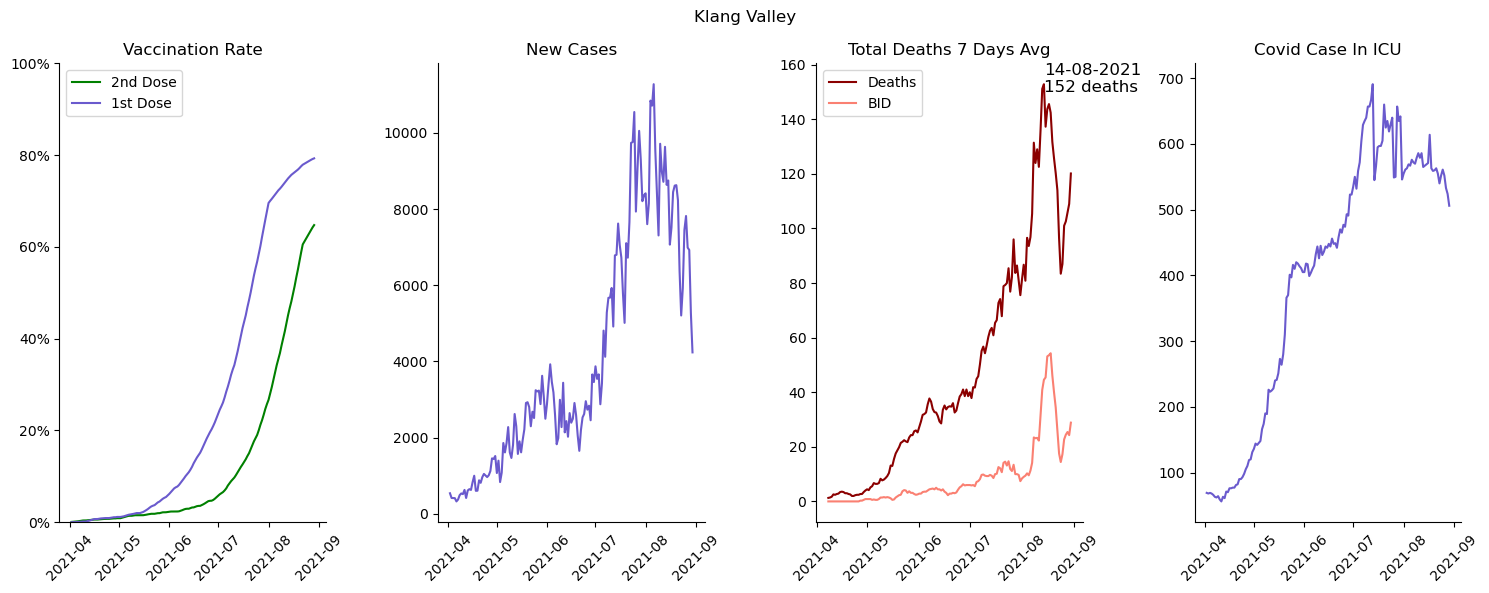

In [382]:
fig, ax = plt.subplots(1,4, figsize= (15,6))

ax[0].plot(sel_dose2_cumsum, color='green', label = '2nd Dose')
ax[0].plot(sel_dose1_cumsum, color='slateblue', label = '1st Dose')

ax[0].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[0].set_ylim(0, 100);
ax[0].tick_params(axis='x', labelrotation=45)
ax[0].legend(loc='upper left')
ax[0].set_title('Vaccination Rate')

ax[1].plot(df_case['cases_new'], color='slateblue')
ax[1].tick_params(axis='x', labelrotation=45)
ax[1].set_title('New Cases');

ax[2].plot(df_case['rolling_death'], label='Deaths', color='darkred')
ax[2].plot(df_case['rolling_death_bid'], label='BID', color='salmon')
ax[2].tick_params(axis='x', labelrotation=45)
ax[2].set_title('Total Deaths 7 Days Avg');
ax[2].text(s=f"{df_case.rolling_death.idxmax().strftime('%d-%m-%Y')}\n{int(df_case.rolling_death.max())} deaths", x=df_case.rolling_death.idxmax(), y=df_case.rolling_death.max()-3, size=12);
ax[2].legend()

ax[3].plot(df_case['covid_in_icu'], color='slateblue')
ax[3].tick_params(axis='x', labelrotation=45)
ax[3].set_title('Covid Case In ICU');

for spine in ax:
    spine.spines['right'].set_visible(False)
    spine.spines['top'].set_visible(False)

fig.suptitle('Klang Valley')
plt.tight_layout()

In [406]:
fasa2 = ['Kelantan', 'Pahang', 'Terengganu', 'Perak', 'Pulau Pinang', 'Sabah']
fasa3 = ['Labuan', 'Sarawak', 'Perlis']

In [401]:
def plot_case(negeri=['Selangor','W.P. Kuala Lumpur'], date_ = 'april 2021'):
    
    population_ = df_population[df_population.state.isin(negeri)]['pop'].sum()
    df_vax_state['date'] = pd.to_datetime(df_vax_state['date'])
    df_death_state['date'] = pd.to_datetime(df_death_state['date'])
    df_cases_state['date'] = pd.to_datetime(df_cases_state['date'])
    df_icu['date'] = pd.to_datetime(df_icu['date'])

    #CUMULATIVE DOSAGES
    """GET TOTAL DOSES"""
    df_vax_state['total_1'] = df_vax_state.pfizer1 + df_vax_state.sinovac1 + df_vax_state.astra1 
    df_vax_state['total_2'] = df_vax_state.pfizer2 + df_vax_state.sinovac2 + df_vax_state.astra2 + df_vax_state.cansino
    """AGGREGATE DOSES"""
    sel_dose2_cumsum = df_vax_state[(df_vax_state.state.isin(negeri)) & (df_vax_state.date>date_)].groupby('date')['total_2'].sum().cumsum() / population_ * 100 #df_population[df_population.state.isin(['Selangor','W.P. Kuala Lumpur'])]['pop'].sum() * 100
    sel_dose1_cumsum = df_vax_state[(df_vax_state.state.isin(negeri)) & (df_vax_state.date>date_)].groupby('date')['total_1'].sum().cumsum() / population_ * 100 #df_population[df_population.state.isin(['Selangor','W.P. Kuala Lumpur'])]['pop'].sum() * 100

    #---------------------------------------------------------------------------------#
    #DAILY DEATH AND BID
    deaths = df_death_state[(df_death_state.state.isin(negeri)) & (df_death_state.date>date_)].groupby('date').sum()

    #DAILY CASES
    cases = df_cases_state[(df_cases_state.state.isin(negeri)) & (df_cases_state.date>date_)].groupby('date')['cases_new'].sum()
    """MAKE A NEW DF FOR PLOTTING"""
    df_case = pd.merge(deaths, cases.to_frame(), how='outer', left_index=True, right_index=True)

    #DAILY DEATH AND BID (ROLLING AVERAGE)
    temp_ = (df_death_state.state.isin(negeri)) & (df_death_state.date>date_)
    df_case['rolling_death'] = df_death_state[temp_].groupby('date')['deaths_new'].sum().rolling(7).mean()
    df_case['rolling_death_bid'] = df_death_state[temp_].groupby('date')['deaths_bid'].sum().rolling(7).mean()


    #DAILY COVID IN ICU
    icu = df_icu[(df_icu.state.isin(negeri)) & (df_icu.date>date_)].groupby('date')['covid_in_icu'].sum()
    df_case = df_case.merge(icu.to_frame(), left_index=True, right_index=True, how='outer')

    df_case['death_per_capita'] = df_case['deaths_new'] / population_ * 1000


    fig, ax = plt.subplots(1,4, figsize= (15,6))

    ax[0].plot(sel_dose2_cumsum, color='green', label = '2nd Dose')
    ax[0].plot(sel_dose1_cumsum, color='slateblue', label = '1st Dose')

    ax[0].yaxis.set_major_formatter(mtick.PercentFormatter())
    ax[0].set_ylim(0, 100);
    ax[0].tick_params(axis='x', labelrotation=45)
    ax[0].legend(loc='upper left')
    ax[0].set_title('Vaccination Rate')

    ax[1].plot(df_case['cases_new'], color='slateblue')
    ax[1].tick_params(axis='x', labelrotation=45)
    ax[1].set_title('New Cases');

    ax[2].plot(df_case['rolling_death'], label='Deaths', color='darkred')
    ax[2].plot(df_case['rolling_death_bid'], label='BID', color='salmon')
    ax[2].tick_params(axis='x', labelrotation=45)
    ax[2].set_title('Total Deaths 7 Days Avg');
    ax[2].text(s=f"{df_case.rolling_death.idxmax().strftime('%d-%m-%Y')}\n{int(df_case.rolling_death.max())} deaths", x=df_case.rolling_death.idxmax(), y=df_case.rolling_death.max(), size=10);
    ax[2].legend()

    ax[3].plot(df_case['covid_in_icu'], color='slateblue')
    ax[3].tick_params(axis='x', labelrotation=45)
    ax[3].set_title('Covid Case In ICU');

    for spine in ax:
        spine.spines['right'].set_visible(False)
        spine.spines['top'].set_visible(False)

    fig.suptitle(f'{negeri}\nafter {date_}')
    plt.tight_layout()

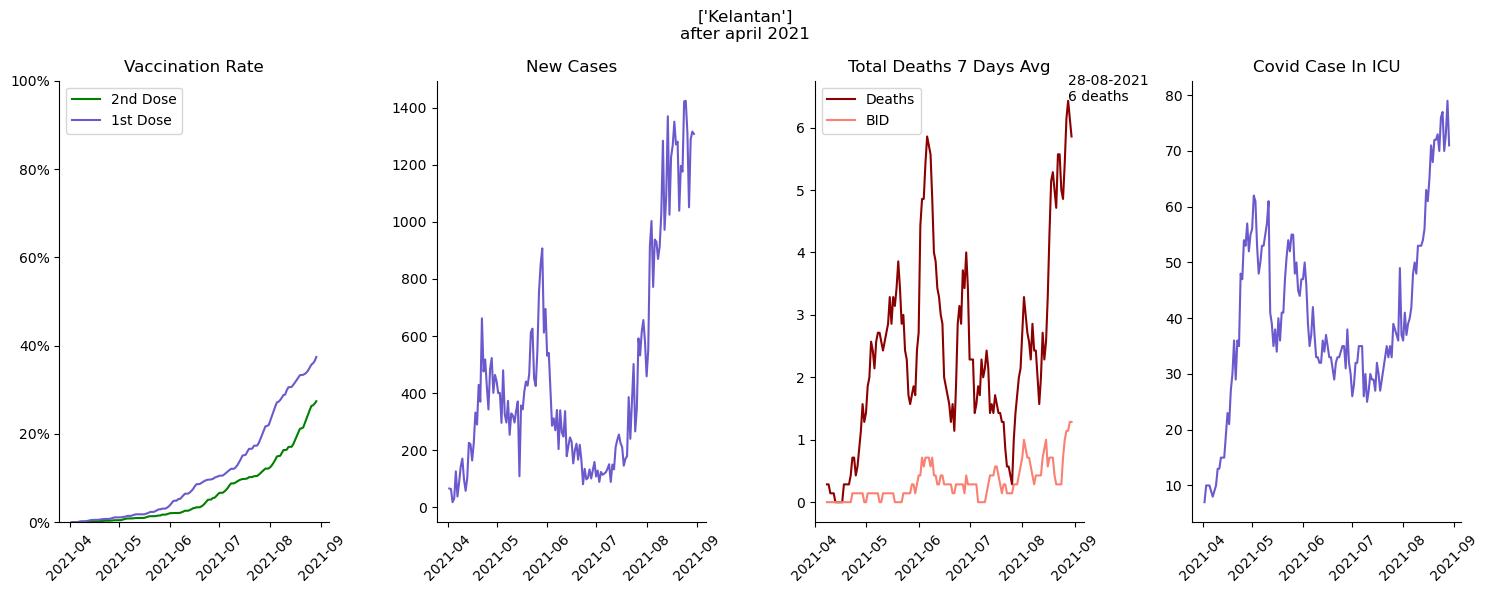

In [402]:
plot_case(['Kelantan'])

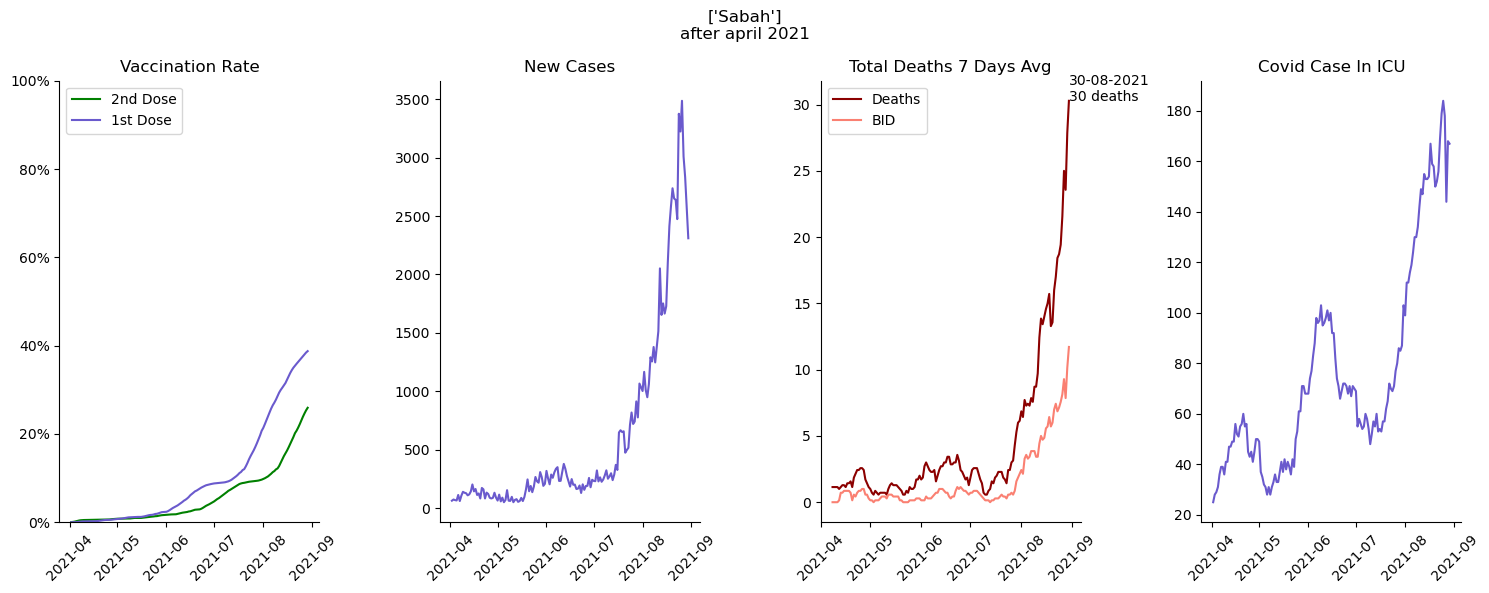

In [405]:
plot_case(['Sabah'])

In [427]:
fasa2 = ['Kelantan', 'Pahang', 'Terengganu', 'Perak', 'Pulau Pinang', 'Sabah']
fasa3 = ['Labuan', 'Sarawak', 'Perlis']

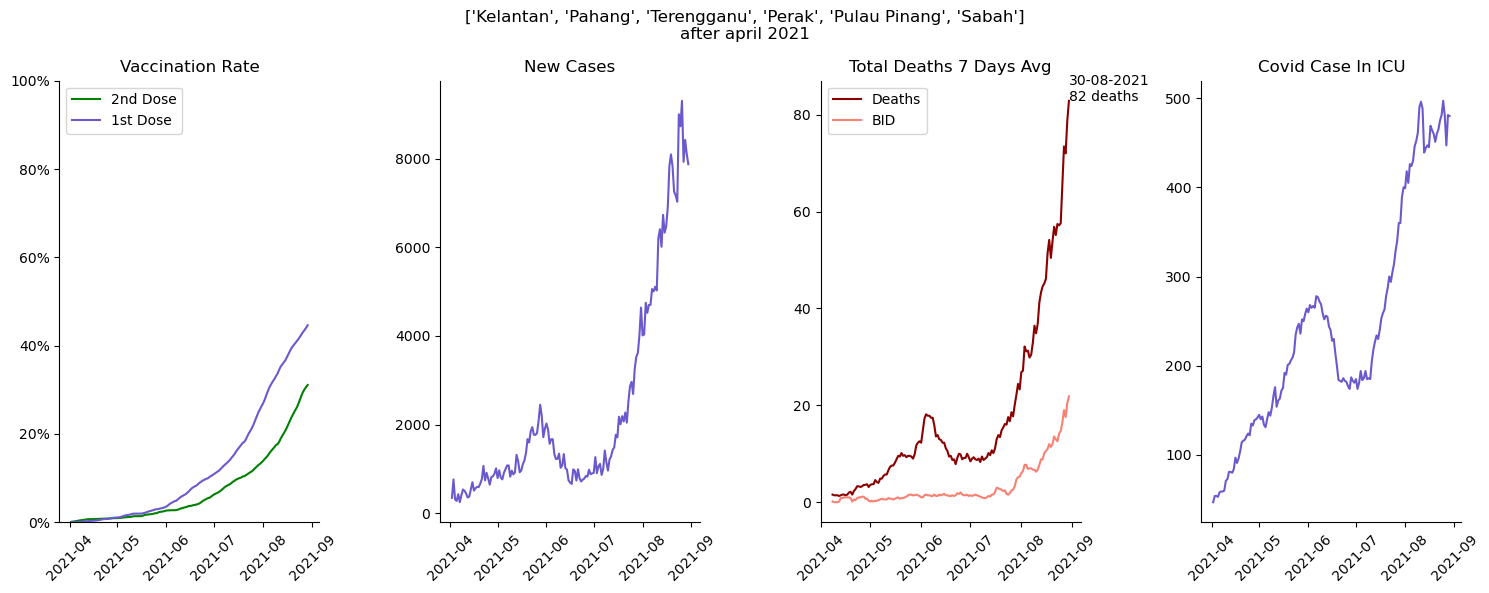

In [404]:
plot_case(fasa2)

### DAILY TEST BY DAY

In [412]:
test_plot = df_tests_malaysia.copy()
test_plot['date'] = pd.to_datetime(test_plot['date'])
test_plot = test_plot[test_plot['date'] > 'april 2021']
test_plot['total_test'] = test_plot.iloc[:,1] + test_plot.iloc[:,2]
test_plot['day'] = test_plot['date'].dt.day_name()
test_plot['day_of_week'] = test_plot['date'].dt.dayofweek

In [408]:
df_tests_malaysia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    583 non-null    object
 1   rtk-ag  583 non-null    int64 
 2   pcr     583 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 13.8+ KB


In [409]:
test_plot.head()

,date,rtk-ag,pcr,total_test,day,day_of_week
0,2020-01-24,0,2,2,Friday,4
1,2020-01-25,0,5,5,Saturday,5
2,2020-01-26,0,14,14,Sunday,6
3,2020-01-27,0,24,24,Monday,0
4,2020-01-28,0,53,53,Tuesday,1


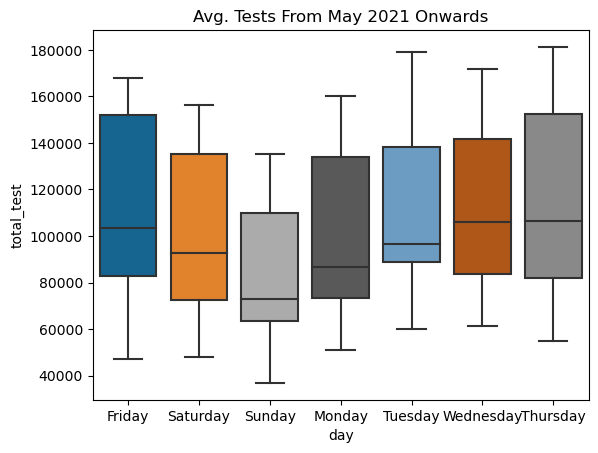

In [416]:
sns.boxplot(x=test_plot.day, y=test_plot.total_test)
plt.title('Avg. Tests From May 2021 Onwards');

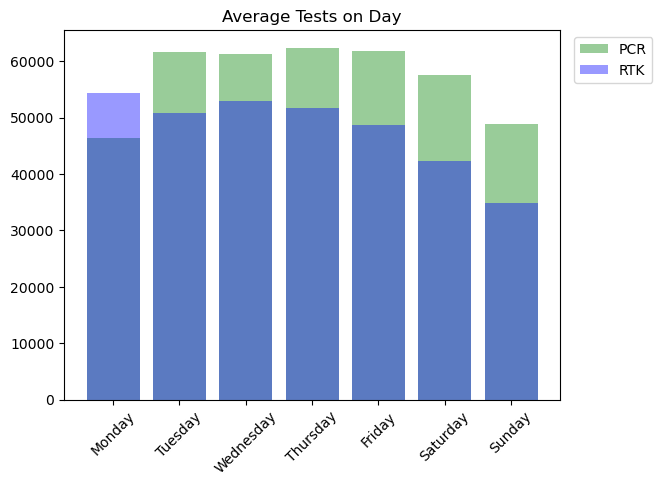

In [420]:
hari = test_plot.groupby('day')[['rtk-ag','pcr','total_test']].mean().reset_index()
hari['day_of_week'] = [5,1,6,7,4,2,3]
hari = hari.sort_values('day_of_week')

fig,ax = plt.subplots()
plt.bar(hari['day'], hari['pcr'], color='green', alpha = 0.4, label='PCR')
plt.bar(hari['day'], hari['rtk-ag'], color='blue', alpha = 0.4, label='RTK')

plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.title('Average Tests on Day')
ax.ticklabel_format(style='plain', axis='y' )
plt.xticks(rotation=45);

### CLUSTER ANALYSYS

In [428]:
df_cluster = pd.read_csv(kluster, parse_dates=['date_announced', 'date_last_onset'])
display(df_cluster.head(), df_cluster.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4731 entries, 0 to 4730
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   cluster          4731 non-null   object        
 1   state            4731 non-null   object        
 2   district         4731 non-null   object        
 3   date_announced   4731 non-null   datetime64[ns]
 4   date_last_onset  4731 non-null   datetime64[ns]
 5   category         4731 non-null   object        
 6   status           4731 non-null   object        
 7   cases_new        4731 non-null   int64         
 8   cases_total      4731 non-null   int64         
 9   cases_active     4731 non-null   int64         
 10  tests            4731 non-null   int64         
 11  icu              4731 non-null   int64         
 12  deaths           4731 non-null   int64         
 13  recovered        4731 non-null   int64         
dtypes: datetime64[ns](2), int64(7), object(5

,cluster,state,district,date_announced,date_last_onset,category,status,cases_new,cases_total,cases_active,tests,icu,deaths,recovered
0,Kluster Warga Jepun,WP Kuala Lumpur,Lembah Pantai,2020-03-01,2020-03-09,import,ended,0,3,0,267,0,0,3
1,Kluster UDA,"WP Kuala Lumpur, WP Putrajaya, Selangor, Neger...",Pelbagai,2020-03-04,2020-03-01,import,ended,0,144,0,1864,0,2,142
2,Kluster Keagamaan (Tabligh SP),Semua Negeri,Pelbagai,2020-03-13,2020-03-11,religious,ended,0,2022,0,42023,0,34,1988
3,Kluster Tabligh New Delhi,"Selangor, Negeri Sembilan, WP Kuala Lumpur & W...",Pelbagai,2020-03-16,2020-03-20,import,ended,0,24,0,57,0,0,24
4,Kluster AIROD,Pahang,Kuantan,2020-03-31,2020-03-31,workplace,ended,0,65,0,734,0,0,65


None

In [429]:
df_cluster.sort_values('cases_new', ascending=False).head(20)

,cluster,state,district,date_announced,date_last_onset,category,status,cases_new,cases_total,cases_active,tests,icu,deaths,recovered
4717,Kluster Industri Dua Batu 16 Setengah Rawang,Selangor,Gombak,2021-08-31,2021-08-30,workplace,active,56,56,56,63,0,0,0
4470,Kluster Industri Mambang Diawan Tiga,Perak,Kampar,2021-08-23,2021-08-30,workplace,active,46,70,70,158,0,0,0
4607,Kluster Jero Gelasah,Sarawak,Subis,2021-08-27,2021-08-30,community,active,35,50,50,72,0,0,0
4721,Kluster Ladang Sri Telang,Pahang,Lipis,2021-08-31,2021-08-30,workplace,active,35,35,35,97,0,0,0
4708,Kluster Jalan Ladang Teh Habu,Pahang,Cameron Highlands,2021-08-30,2021-08-30,community,active,34,49,49,171,0,0,0
4718,Kluster Ladang Renjok,Pahang,Bentong,2021-08-31,2021-08-30,workplace,active,33,56,56,155,0,0,0
1983,Kluster Industri Kelemak,"Negeri Sembilan, Melaka","Tampin, Alor Gajah, Melaka Tengah, Jasin",2021-05-21,2021-08-30,workplace,active,31,975,384,2111,4,4,587
4719,Kluster Sawit Jeroco,Sabah,Lahad Datu,2021-08-31,2021-08-30,workplace,active,25,55,55,249,0,0,0
3567,Kluster Industri Persiaran Cassia Selatan,"Pulau Pinang, Perak","Seberang Perai Selatan, Seberang Perai Tengah,...",2021-07-28,2021-08-30,workplace,active,24,208,125,406,0,0,83
4078,Kluster Bungey 2,Sarawak,"Betong, Pusa",2021-08-12,2021-08-30,community,active,22,640,383,700,1,0,257


In [430]:
KV_cluster = df_cluster[(df_cluster['state'].str.contains('Selangor'))  & (df_cluster['status'] =='active') & (df_cluster['state'].str.contains('Kuala Lumpur'))].sort_values('cases_new', ascending=False).reset_index(drop=True)
KV_cluster.head(20)

,cluster,state,district,date_announced,date_last_onset,category,status,cases_new,cases_total,cases_active,tests,icu,deaths,recovered
0,Kluster Jalan Jaya 2,"WP Kuala Lumpur, Selangor","Cheras, Titiwangsa, Lembah Pantai, Kepong, Hul...",2021-06-05,2021-08-05,highRisk,active,0,227,36,402,1,0,191
1,Kluster Jalan SS Lapan Empat,"Selangor, WP Kuala Lumpur, WP Putrajaya","Gombak, Petaling, Hulu Langat, Kuala Langat, K...",2021-06-10,2021-08-27,workplace,active,0,175,6,737,0,0,169
2,Kluster Industri SS Lapan Sungai Way,"Selangor, WP Kuala Lumpur","Petaling, Klang, Hulu Selangor, Kuala Selangor...",2021-06-22,2021-08-27,workplace,active,0,195,24,1157,0,1,170
3,Kluster Jalan Metro Perdana,"WP Kuala Lumpur, Selangor","Kepong, Titiwangsa, Gombak, Petaling, Kuala Se...",2021-07-07,2021-08-13,workplace,active,0,63,0,141,0,0,63
4,Kluster Jalan Pahat 15,"Selangor, WP Kuala Lumpur, Negeri Sembilan, Perak","Petaling, Sepang, Kuala Selangor, Kuala Langat...",2021-07-14,2021-08-05,highRisk,active,0,166,3,471,0,0,163
5,Kluster Jalan Pinang,"WP Kuala Lumpur, Selangor","Lembah Pantai, Titiwangsa, Gombak, Kepong",2021-07-15,2021-08-06,workplace,active,0,41,20,125,0,0,21
6,Kluster Bintang Meranti,"WP Kuala Lumpur, Selangor","Lembah Pantai, Cheras, Titiwangsa, Kepong, Hul...",2021-07-15,2021-08-17,workplace,active,0,20,5,216,0,0,15
7,Kluster Jalan Batu Caves,"Selangor, WP Kuala Lumpur","Gombak, Hulu Selangor, Kepong",2021-08-05,2021-08-10,workplace,active,0,50,2,150,0,0,48


In [431]:
df_cluster_gb = df_cluster.groupby('date_announced')['category'].apply(lambda x: x.value_counts())
df_cluster_gb = pd.DataFrame(df_cluster_gb)
df_cluster_gb.head(3)
# sns.countplot(x='category',data=df_cluster_gb)
# plt.xticks(rotation=45)

,,category
date_announced,,
2020-03-01,import,1
2020-03-04,import,1
2020-03-13,religious,1


In [432]:
df_cluster_gb2 = df_cluster_gb.reset_index()
df_cluster_gb2.columns = ['date', 'category','new_cluster']
# df_cluster_gb2 = df_cluster_gb2.set_index('date')
df_cluster_gb2 = df_cluster_gb2[df_cluster_gb2['date'] > 'May 2021']
df_cluster_gb2 = df_cluster_gb2.pivot_table(index='date', columns=['category'], values='new_cluster')
df_cluster_gb2 = df_cluster_gb2.resample('W').sum()

df_cluster_gb2.head()

category,community,detentionCentre,education,highRisk,import,religious,workplace
date,,,,,,,
2021-05-02,5.0,0.0,4.0,0.0,0.0,0.0,2.0
2021-05-09,33.0,1.0,16.0,1.0,0.0,10.0,47.0
2021-05-16,21.0,0.0,14.0,4.0,0.0,19.0,41.0
2021-05-23,43.0,0.0,5.0,3.0,0.0,34.0,53.0
2021-05-30,45.0,2.0,7.0,3.0,1.0,22.0,58.0


Text(0, 0.5, 'new cluster in a week')

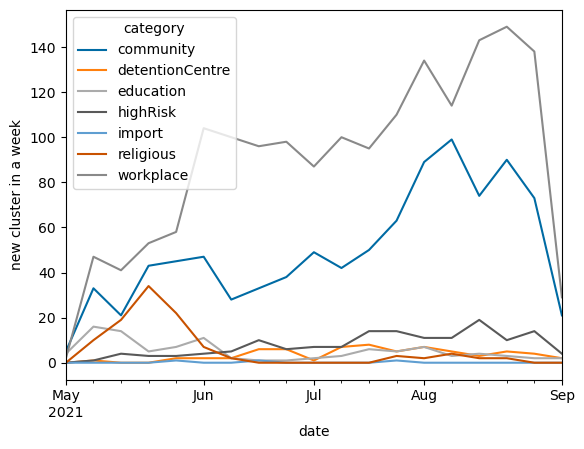

In [433]:
df_cluster_gb2.plot.line()
plt.ylabel('new cluster in a week')